# **w261 Final Project - Clickthrough Rate Prediction**

Team Number:19

Team Members: Steve Dille, Naga Akkineni, Joanna Yu, Pauline Wang

Fall 2019, section [Your section numbers>]

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
import pyspark.sql.functions as F
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_proj"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [4]:
spark

Create toyDF 

In [5]:
#create spark dataframe
toyDF = spark.read.load("data/toy_naga.parquet")
#print Schema
toyDF.printSchema()
#convert all Label, Integer columns to Ints
from pyspark.sql.types import IntegerType
toyDF = toyDF.withColumn("Label", toyDF["Label"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-1", toyDF["I-1"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-2", toyDF["I-2"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-3", toyDF["I-3"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-4", toyDF["I-4"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-5", toyDF["I-5"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-6", toyDF["I-6"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-7", toyDF["I-7"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-8", toyDF["I-8"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-9", toyDF["I-9"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-10", toyDF["I-10"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-11", toyDF["I-11"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-12", toyDF["I-12"].cast(IntegerType()))
toyDF = toyDF.withColumn("I-13", toyDF["I-13"].cast(IntegerType()))

root
 |-- Label: string (nullable = true)
 |-- I-1: string (nullable = true)
 |-- I-2: string (nullable = true)
 |-- I-3: string (nullable = true)
 |-- I-4: string (nullable = true)
 |-- I-5: string (nullable = true)
 |-- I-6: string (nullable = true)
 |-- I-7: string (nullable = true)
 |-- I-8: string (nullable = true)
 |-- I-9: string (nullable = true)
 |-- I-10: string (nullable = true)
 |-- I-11: string (nullable = true)
 |-- I-12: string (nullable = true)
 |-- I-13: string (nullable = true)
 |-- C-1: string (nullable = true)
 |-- C-2: string (nullable = true)
 |-- C-3: string (nullable = true)
 |-- C-4: string (nullable = true)
 |-- C-5: string (nullable = true)
 |-- C-6: string (nullable = true)
 |-- C-7: string (nullable = true)
 |-- C-8: string (nullable = true)
 |-- C-9: string (nullable = true)
 |-- C-10: string (nullable = true)
 |-- C-11: string (nullable = true)
 |-- C-12: string (nullable = true)
 |-- C-13: string (nullable = true)
 |-- C-14: string (nullable = true)
 |--

In [6]:
# Get the counts of empty values in toy set as well as train set

all_columns = ["Label","I-1","I-2","I-3","I-4","I-5","I-6","I-7","I-8","I-9","I-10","I-11",
               "I-12","I-13","C-1","C-2","C-3","C-4","C-5","C-6","C-7","C-8","C-9","C-10",
              "C-11","C-12","C-13","C-14","C-15","C-16","C-17","C-18","C-19","C-20","C-21"
              ,"C-22","C-23","C-24","C-25","C-26"]
continuous_indexes = [i for i in range(1,14)]
category_indexes = [i for i in range(14,40)]

def getEmptyCategoryCounts(dataframe):
    print("Missing values")
    print("--------------------------------------")
    for i in range(1,40):
        col_name = all_columns[i]
        count = dataframe.filter((dataframe[col_name] == "") | dataframe[col_name].isNull() | isnan(dataframe[col_name])).count()
        print('{}\t\t\t {}'.format(col_name, count))

print("--------------------------------------")
print("TOY SET")
print("--------------------------------------")
       
%time getEmptyCategoryCounts(toyDF)

print("--------------------------------------")
print("TRAIN SET")
print("--------------------------------------")

trainDF = spark.read.load("data/train_80.parquet")
%time getEmptyCategoryCounts(trainDF)

--------------------------------------
TOY SET
--------------------------------------
Missing values
--------------------------------------


NameError: name 'isnan' is not defined

--------------------------------------
TRAIN SET
--------------------------------------
Missing values
--------------------------------------


NameError: name 'isnan' is not defined

In [7]:
toyDF.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I-1: integer (nullable = true)
 |-- I-2: integer (nullable = true)
 |-- I-3: integer (nullable = true)
 |-- I-4: integer (nullable = true)
 |-- I-5: integer (nullable = true)
 |-- I-6: integer (nullable = true)
 |-- I-7: integer (nullable = true)
 |-- I-8: integer (nullable = true)
 |-- I-9: integer (nullable = true)
 |-- I-10: integer (nullable = true)
 |-- I-11: integer (nullable = true)
 |-- I-12: integer (nullable = true)
 |-- I-13: integer (nullable = true)
 |-- C-1: string (nullable = true)
 |-- C-2: string (nullable = true)
 |-- C-3: string (nullable = true)
 |-- C-4: string (nullable = true)
 |-- C-5: string (nullable = true)
 |-- C-6: string (nullable = true)
 |-- C-7: string (nullable = true)
 |-- C-8: string (nullable = true)
 |-- C-9: string (nullable = true)
 |-- C-10: string (nullable = true)
 |-- C-11: string (nullable = true)
 |-- C-12: string (nullable = true)
 |-- C-13: string (nullable = true)
 |-- C-14: string (nullabl

In [8]:
toyDF.show()

+-----+----+----+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|Label| I-1| I-2| I-3| I-4|  I-5| I-6| I-7|I-8| I-9|I-10|I-11|I-12|I-13|     C-1|     C-2|     C-3|     C-4|     C-5|     C-6|     C-7|     C-8|     C-9|    C-10|    C-11|    C-12|    C-13|    C-14|    C-15|    C-16|    C-17|    C-18|    C-19|    C-20|    C-21|    C-22|    C-23|    C-24|    C-25|    C-26|
+-----+----+----+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    0|   0|   2|null|   1| 4767|  40|   1|  7|  40|   0|   1|null|   1|5a9ed9b

In [9]:
def string_indexers(dataframe):
    indexers = [StringIndexer(inputCol=all_columns[i], outputCol=all_columns[i]+"-Index").fit(dataframe) for 
                i in category_indexes ]
    pipeline = Pipeline(stages=indexers)
    indexed_dataframe = pipeline.fit(dataframe).transform(dataframe)
    for i in category_indexes:
        indexed_dataframe = indexed_dataframe.drop(all_columns[i])
    return indexed_dataframe
toy_indexedDF   = string_indexers(toyDF)
toy_indexedDF.show()

+-----+----+----+----+----+-----+----+----+---+----+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Label| I-1| I-2| I-3| I-4|  I-5| I-6| I-7|I-8| I-9|I-10|I-11|I-12|I-13|C-1-Index|C-2-Index|C-3-Index|C-4-Index|C-5-Index|C-6-Index|C-7-Index|C-8-Index|C-9-Index|C-10-Index|C-11-Index|C-12-Index|C-13-Index|C-14-Index|C-15-Index|C-16-Index|C-17-Index|C-18-Index|C-19-Index|C-20-Index|C-21-Index|C-22-Index|C-23-Index|C-24-Index|C-25-Index|C-26-Index|
+-----+----+----+----+----+-----+----+----+---+----+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------

In [10]:
toy_indexedDF = toy_indexedDF.fillna(0)
toy_indexedDF.show()

+-----+---+----+---+---+-----+---+---+---+---+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Label|I-1| I-2|I-3|I-4|  I-5|I-6|I-7|I-8|I-9|I-10|I-11|I-12|I-13|C-1-Index|C-2-Index|C-3-Index|C-4-Index|C-5-Index|C-6-Index|C-7-Index|C-8-Index|C-9-Index|C-10-Index|C-11-Index|C-12-Index|C-13-Index|C-14-Index|C-15-Index|C-16-Index|C-17-Index|C-18-Index|C-19-Index|C-20-Index|C-21-Index|C-22-Index|C-23-Index|C-24-Index|C-25-Index|C-26-Index|
+-----+---+----+---+---+-----+---+---+---+---+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--

#apply vector assembler for numeric columns


va_I_1  = VectorAssembler(inputCols=["I-1"], outputCol="I-1-Vector")
va_I_2  = VectorAssembler(inputCols=["I-2"], outputCol="I-2-Vector")
va_I_3  = VectorAssembler(inputCols=["I-3"], outputCol="I-3-Vector")
va_I_4  = VectorAssembler(inputCols=["I-4"], outputCol="I-4-Vector")
va_I_5  = VectorAssembler(inputCols=["I-5"], outputCol="I-5-Vector")
va_I_6  = VectorAssembler(inputCols=["I-6"], outputCol="I-6-Vector")
va_I_7  = VectorAssembler(inputCols=["I-7"], outputCol="I-7-Vector")
va_I_8  = VectorAssembler(inputCols=["I-8"], outputCol="I-8-Vector")
va_I_9  = VectorAssembler(inputCols=["I-9"], outputCol="I-9-Vector")
va_I_10 = VectorAssembler(inputCols=["I-10"], outputCol="I-10-Vector")
va_I_11 = VectorAssembler(inputCols=["I-11"], outputCol="I-11-Vector")
va_I_12 = VectorAssembler(inputCols=["I-12"], outputCol="I-12-Vector")
va_I_13 = VectorAssembler(inputCols=["I-13"], outputCol="I-13-Vector")

toy_indexedDF = va_I_1.transform(toy_indexedDF)
toy_indexedDF = va_I_2.transform(toy_indexedDF)
toy_indexedDF = va_I_3.transform(toy_indexedDF)
toy_indexedDF = va_I_4.transform(toy_indexedDF)
toy_indexedDF = va_I_5.transform(toy_indexedDF)
toy_indexedDF = va_I_6.transform(toy_indexedDF)
toy_indexedDF = va_I_7.transform(toy_indexedDF)
toy_indexedDF = va_I_8.transform(toy_indexedDF)
toy_indexedDF = va_I_9.transform(toy_indexedDF)
toy_indexedDF = va_I_10.transform(toy_indexedDF)
toy_indexedDF = va_I_11.transform(toy_indexedDF)
toy_indexedDF = va_I_12.transform(toy_indexedDF)
toy_indexedDF = va_I_13.transform(toy_indexedDF)




In [11]:
temp = toy_indexedDF

In [12]:
def assembler_indexers(dataframe):
    assemblers = [VectorAssembler(inputCols=[all_columns[i]], outputCol=all_columns[i]+"-Vector") for 
                i in continuous_indexes ]
    pipeline = Pipeline(stages=assemblers)
    assembled_dataframe = pipeline.fit(dataframe).transform(dataframe)
    #for i in continuous_indexes:
        #indexed_dataframe = indexed_dataframe.drop(all_columns[i])
    return assembled_dataframe

toy_assembled_indexedDF   = assembler_indexers(toy_indexedDF)


In [13]:
#apply standard scaler to numeric columns
def scaler_indexers(dataframe):
    indexers = [StandardScaler(inputCol=all_columns[i]+"-Vector", outputCol=all_columns[i]+"-Scaled",
                        withStd=True, withMean=False).fit(dataframe) for 
                i in continuous_indexes ]
    pipeline = Pipeline(stages=indexers)
    scaled_dataframe = pipeline.fit(dataframe).transform(dataframe)
    #for i in continuous_indexes:
        #indexed_dataframe = indexed_dataframe.drop(all_columns[i])
    return scaled_dataframe

toy_scaled_indexedDF   = scaler_indexers(toy_assembled_indexedDF)



In [14]:
toy_scaled_indexedDF.show(n=20)

+-----+---+----+---+---+-----+---+---+---+---+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+
|Label|I-1| I-2|I-3|I-4|  I-5|I-6|I-7|I-8|I-9|I-10|I-11|I-12|I-13|C-1-Index|C-2-Index|C-3-Index|C-4-Index|C-5-Index|C-6-Index|C-7-Index|C-8-Index|C-9-Index|C-10-Index|C-11-Index|C-12-Index|C-13-Index|C-14-Index|C-15-Index|C-16-Index|C-17-Index|C

Pauline Breiman Below

In [14]:
toy_scaled_indexedDF.show(n=3)

+-----+---+---+---+---+----+---+---+---+---+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-----------+--------------------+
|Label|I-1|I-2|I-3|I-4| I-5|I-6|I-7|I-8|I-9|I-10|I-11|I-12|I-13|C-1-Index|C-2-Index|C-3-Index|C-4-Index|C-5-Index|C-6-Index|C-7-Index|C-8-Index|C-9-Index|C-10-Index|C-11-Index|C-12-Index|C-13-Index|C-14-Index|C-15-Index|C-16-Index|C-17-Index|C-18-Index|C-19-Index|C-

In [35]:
# Help function: We replace all the categorical values that are greater than 100 with 999 (aka we only keep the 100 most frequently appear categorical values)

from pyspark.sql.functions import when

def drop_threshold(df, threshold, replace_val, column_names):
    '''Help function that replace all values greater than a threshold with the replacement value'''
    for col in column_names:
        df=df.withColumn(col, when(df[col]>threshold, replace_val).otherwise(df[col]))
    return df


In [36]:
#Rename the new DF  to toy_SID_DF (SID = scaled, indexed, dropped)
categorical_columns=["C-1-Index","C-2-Index","C-3-Index","C-4-Index","C-5-Index","C-6-Index","C-7-Index","C-8-Index","C-9-Index","C-10-Index","C-11-Index","C-12-Index", "C-13-Index","C-14-Index","C-15-Index","C-16-Index","C-17-Index","C-18-Index","C-19-Index","C-20-Index","C-21-Index", "C-22-Index","C-23-Index","C-24-Index","C-25-Index","C-26-Index"]
toy_SID_DF = drop_threshold (toy_scaled_indexedDF, 100, 999, categorical_columns)
toy_SID_DF.show(n=3) #take a look to see that all values greater than threshold (e.g.100) is replaced by replaced value (e.g.999)

+-----+---+---+---+---+----+---+---+---+---+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-----------+--------------------+
|Label|I-1|I-2|I-3|I-4| I-5|I-6|I-7|I-8|I-9|I-10|I-11|I-12|I-13|C-1-Index|C-2-Index|C-3-Index|C-4-Index|C-5-Index|C-6-Index|C-7-Index|C-8-Index|C-9-Index|C-10-Index|C-11-Index|C-12-Index|C-13-Index|C-14-Index|C-15-Index|C-16-Index|C-17-Index|C-18-Index|C-19-Index|C-

In [57]:
#Helper function: We apply Breiman function to all categorical columns

def Breiman(df, label_column, column_names):
    '''This function calculates the average of a given column conditional on the value of another column'''
    for col in column_names:
        print(col)
        lookup_df=df.groupby(col).mean(label_column)#build the lookup table
        ta = lookup_df.alias('ta')
        tb = df.alias('tb')
        df=tb.join(ta,ta[col] == tb[col]).drop(col).withColumnRenamed("avg(Label)",col)
    return df
categorical_columns=["C-1-Index","C-3-Index","C-4-Index"]
toy_SIDB_DF=Breiman(toy_SID_DF, "Label", categorical_columns)
toy_SIDB_DF.show(n=5)



lookup_DF=toy_SID_DF.groupby("C-1-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SID_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-1-Index"] == tb["C-1-Index"]).drop("C-1-Index").withColumnRenamed("avg(Label)","C-1-Index")

lookup_DF=toy_SID_DF.groupby("C-2-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SIDB_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-2-Index"] == tb["C-2-Index"]).drop("C-2-Index").withColumnRenamed("avg(Label)","C-2-Index")

lookup_DF=toy_SID_DF.groupby("C-3-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SIDB_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-3-Index"] == tb["C-3-Index"]).drop("C-3-Index").withColumnRenamed("avg(Label)","C-3-Index")

lookup_DF=toy_SID_DF.groupby("C-4-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SID_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-6-Index"] == tb["C-6-Index"]).drop("C-6-Index").withColumnRenamed("avg(Label)","C-6-Index")

lookup_DF=toy_SID_DF.groupby("C-3-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SIDB_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-3-Index"] == tb["C-3-Index"]).drop("C-3-Index").withColumnRenamed("avg(Label)","C-3-Index")

lookup_DF=toy_SID_DF.groupby("C-4-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SIDB_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-4-Index"] == tb["C-4-Index"]).drop("C-4-Index").withColumnRenamed("avg(Label)","C-4-Index")

lookup_DF=toy_SID_DF.groupby("C-6-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SID_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-6-Index"] == tb["C-6-Index"]).drop("C-6-Index").withColumnRenamed("avg(Label)","C-6-Index")

lookup_DF=toy_SID_DF.groupby("C-3-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SIDB_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-3-Index"] == tb["C-3-Index"]).drop("C-3-Index").withColumnRenamed("avg(Label)","C-3-Index")

lookup_DF=toy_SID_DF.groupby("C-4-Index").mean("Label")
ta= lookup_DF.alias('ta')
tb=toy_SIDB_DF.alias('tb')
toy_SIDB_DF=tb.join(ta,ta["C-4-Index"] == tb["C-4-Index"]).drop("C-4-Index").withColumnRenamed("avg(Label)","C-4-Index")

+-----+---+---+---+---+----+---+---+---+---+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-----------+--------------------+------------------+
|Label|I-1|I-2|I-3|I-4| I-5|I-6|I-7|I-8|I-9|I-10|I-11|I-12|I-13|C-1-Index|C-2-Index|C-3-Index|C-4-Index|C-5-Index|C-7-Index|C-8-Index|C-9-Index|C-10-Index|C-11-Index|C-12-Index|C-13-Index|C-14-Index|C-15-Index|C-16-Index|C-17-Index|C-18-Index|C-19-Index|C-2

#fill all Integer columns `NA` to `0'
toyDF = toyDF.fillna(0)
# Replace all categorical string `empty` to `null`
toyDF = toyDF.replace('', 'null')
# convert all `hex` code to `int`
from pyspark.sql.functions import conv
toyDF = toyDF.withColumn('C-1', conv('C-1', 16, 10))
toyDF = toyDF.withColumn('C-2', conv('C-2', 16, 10))
toyDF = toyDF.withColumn('C-3', conv('C-3', 16, 10))
toyDF = toyDF.withColumn('C-4', conv('C-4', 16, 10))
toyDF = toyDF.withColumn('C-5', conv('C-5', 16, 10))
toyDF = toyDF.withColumn('C-6', conv('C-6', 16, 10))
toyDF = toyDF.withColumn('C-7', conv('C-7', 16, 10))
toyDF = toyDF.withColumn('C-8', conv('C-8', 16, 10))
toyDF = toyDF.withColumn('C-9', conv('C-9', 16, 10))
toyDF = toyDF.withColumn('C-10', conv('C-10', 16, 10))
toyDF = toyDF.withColumn('C-11', conv('C-11', 16, 10))
toyDF = toyDF.withColumn('C-12', conv('C-12', 16, 10))
toyDF = toyDF.withColumn('C-13', conv('C-13', 16, 10))
toyDF = toyDF.withColumn('C-14', conv('C-14', 16, 10))
toyDF = toyDF.withColumn('C-15', conv('C-15', 16, 10))
toyDF = toyDF.withColumn('C-16', conv('C-16', 16, 10))
toyDF = toyDF.withColumn('C-17', conv('C-17', 16, 10))
toyDF = toyDF.withColumn('C-18', conv('C-18', 16, 10))
toyDF = toyDF.withColumn('C-19', conv('C-19', 16, 10))
toyDF = toyDF.withColumn('C-20', conv('C-20', 16, 10))
toyDF = toyDF.withColumn('C-21', conv('C-21', 16, 10))
toyDF = toyDF.withColumn('C-22', conv('C-22', 16, 10))
toyDF = toyDF.withColumn('C-23', conv('C-23', 16, 10))
toyDF = toyDF.withColumn('C-24', conv('C-24', 16, 10))
toyDF = toyDF.withColumn('C-25', conv('C-25', 16, 10))
toyDF = toyDF.withColumn('C-26', conv('C-26', 16, 10))
#check if its good
toyDF.show()
# convert all categorial feature columns from strin to long type
from pyspark.sql.types import LongType
toyDF = toyDF.withColumn("C-1", toyDF["C-1"].cast(LongType()))
toyDF = toyDF.withColumn("C-2", toyDF["C-2"].cast(LongType()))
toyDF = toyDF.withColumn("C-3", toyDF["C-3"].cast(LongType()))
toyDF = toyDF.withColumn("C-4", toyDF["C-4"].cast(LongType()))
toyDF = toyDF.withColumn("C-5", toyDF["C-5"].cast(LongType()))
toyDF = toyDF.withColumn("C-6", toyDF["C-6"].cast(LongType()))
toyDF = toyDF.withColumn("C-7", toyDF["C-7"].cast(LongType()))
toyDF = toyDF.withColumn("C-8", toyDF["C-8"].cast(LongType()))
toyDF = toyDF.withColumn("C-9", toyDF["C-9"].cast(LongType()))
toyDF = toyDF.withColumn("C-10", toyDF["C-10"].cast(LongType()))
toyDF = toyDF.withColumn("C-11", toyDF["C-11"].cast(LongType()))
toyDF = toyDF.withColumn("C-12", toyDF["C-12"].cast(LongType()))
toyDF = toyDF.withColumn("C-13", toyDF["C-13"].cast(LongType()))
toyDF = toyDF.withColumn("C-14", toyDF["C-14"].cast(LongType()))
toyDF = toyDF.withColumn("C-15", toyDF["C-15"].cast(LongType()))
toyDF = toyDF.withColumn("C-16", toyDF["C-16"].cast(LongType()))
toyDF = toyDF.withColumn("C-17", toyDF["C-17"].cast(LongType()))
toyDF = toyDF.withColumn("C-18", toyDF["C-18"].cast(LongType()))
toyDF = toyDF.withColumn("C-19", toyDF["C-19"].cast(LongType()))
toyDF = toyDF.withColumn("C-20", toyDF["C-20"].cast(LongType()))
toyDF = toyDF.withColumn("C-21", toyDF["C-21"].cast(LongType()))
toyDF = toyDF.withColumn("C-22", toyDF["C-22"].cast(LongType()))
toyDF = toyDF.withColumn("C-23", toyDF["C-23"].cast(LongType()))
toyDF = toyDF.withColumn("C-24", toyDF["C-24"].cast(LongType()))
toyDF = toyDF.withColumn("C-25", toyDF["C-25"].cast(LongType()))
toyDF = toyDF.withColumn("C-26", toyDF["C-26"].cast(LongType()))
# verify the schema
toyDF.printSchema()
# verify the data
toyDF.show()

In [18]:
toyDF[['Label']].describe().show()

+-------+-------------------+
|summary|              Label|
+-------+-------------------+
|  count|             549101|
|   mean|0.25598022950240484|
| stddev| 0.4364111575733494|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [19]:
toyDF[['I-2']].describe().show()

+-------+------------------+
|summary|               I-2|
+-------+------------------+
|  count|            549101|
|   mean|106.32484916254022|
| stddev|393.48202122021956|
|    min|                -3|
|    max|             20547|
+-------+------------------+



AttributeError: 'str' object has no attribute 'conjugate'

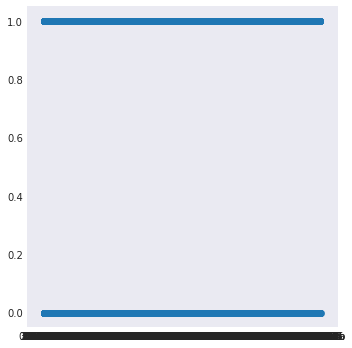

In [20]:
#s_df = toyDF.select(['Label', 'I-10']) \
       #     .sample(withReplacement=False, fraction=0.5, seed=42)

# Create a Pandas df from a subset of columns, those that are sampled
#s_df_pandas = s_df.toPandas() 

# Or the entire Spark df
df_pandas = toyDF.toPandas()

# A basic seaborn linear model plot
sns.lmplot(y = 'Label', x = 'C-2', data=df_pandas)

In [12]:
# Assess percentage of label categories
df_pandas.shape
df_pandas.Label.value_counts(dropna=False)/len(df_pandas)

0    0.74402
1    0.25598
Name: Label, dtype: float64

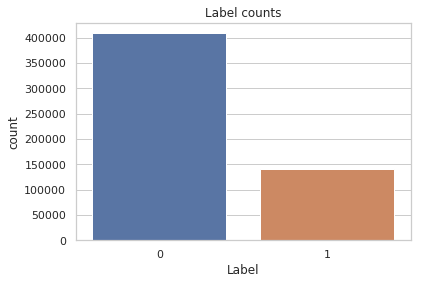

In [13]:
# plot distribution of label counts
sns.set(style="whitegrid")
ax = sns.countplot(x="Label", data=df_pandas)
ax.set(title="Label counts")
plt.show()

In [17]:
#Explore mean values of integer variables with respect to label categories
df_pandas.groupby(df_pandas.Label)['I-1', 'I-2', 'I-3', 'I-4',
       'I-5', 'I-6', 'I-7', 'I-8', 'I-9',
       'I-10', 'I-11', 'I-12', 'I-13'].mean()

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
Label,,,,,,,,,,,,,
0,1.481231,96.326745,19.309459,6.017773,21008.457126,100.676895,12.474174,12.796254,98.685455,0.271977,2.160157,0.154652,7.112304
1,3.169914,135.384856,24.286492,4.921677,9106.997752,59.314466,24.991541,11.681870,110.918767,0.525103,3.985152,0.461557,4.514425


In [18]:
#Explore median values of integer variables with respect to label categories.

df_pandas.groupby(df_pandas.Label)['I-1', 'I-2', 'I-3', 'I-4',
       'I-5', 'I-6', 'I-7', 'I-8', 'I-9',
       'I-10', 'I-11', 'I-12', 'I-13'].median()

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
Label,,,,,,,,,,,,,
0,0.0,3.0,4.0,3.0,3060.5,19.0,2.0,8.0,35.0,0.0,1.0,0.0,3.0
1,0.0,3.0,3.0,2.0,1350.0,10.0,6.0,6.0,35.0,0.0,2.0,0.0,2.0


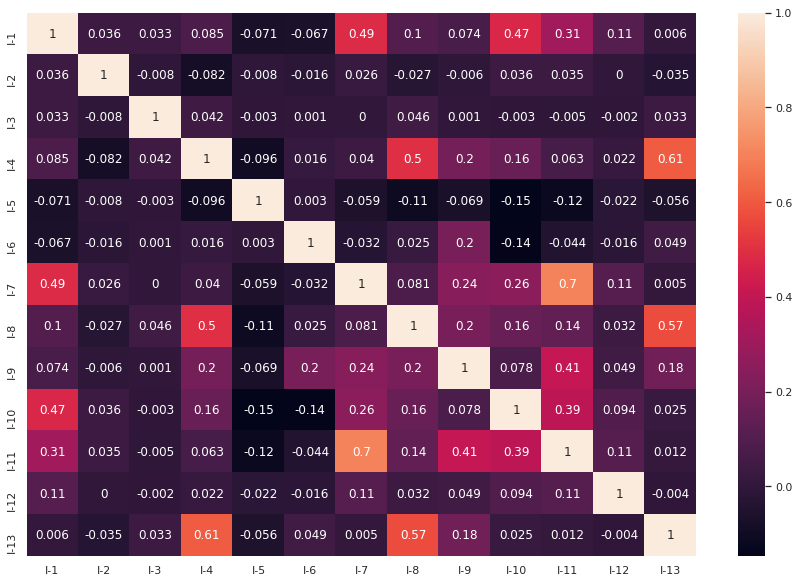

In [27]:
#Heat Map of Integers
integer_correlations = df_pandas.iloc[:,1:14].corr()
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(integer_correlations.round(3), xticklabels=integer_correlations.columns, yticklabels=integer_correlations.columns, annot=True)
plt.show()

I-1
[  0.   50.2 100.4 150.6 200.8 251.  301.2 351.4 401.6 451.8 502. ]


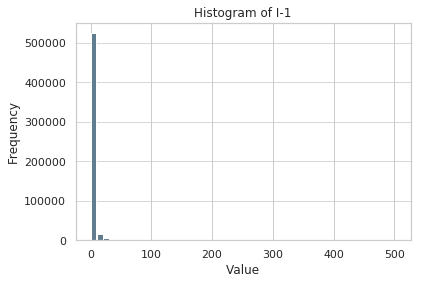

I-2
[-3.0000e+00  2.0520e+03  4.1070e+03  6.1620e+03  8.2170e+03  1.0272e+04
  1.2327e+04  1.4382e+04  1.6437e+04  1.8492e+04  2.0547e+04]


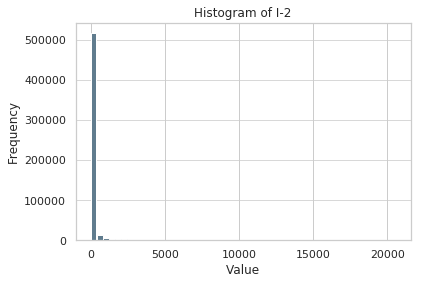

I-3
[    0.   6553.5 13107.  19660.5 26214.  32767.5 39321.  45874.5 52428.
 58981.5 65535. ]


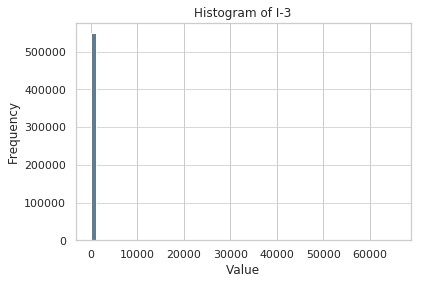

I-4
[  0.   39.1  78.2 117.3 156.4 195.5 234.6 273.7 312.8 351.9 391. ]


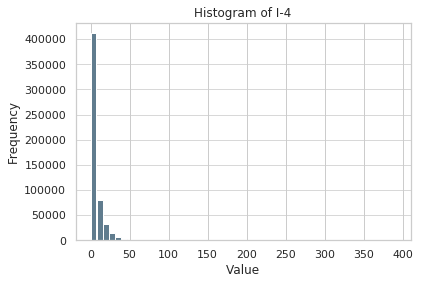

I-5
[      0.   237896.4  475792.8  713689.2  951585.6 1189482.  1427378.4
 1665274.8 1903171.2 2141067.6 2378964. ]


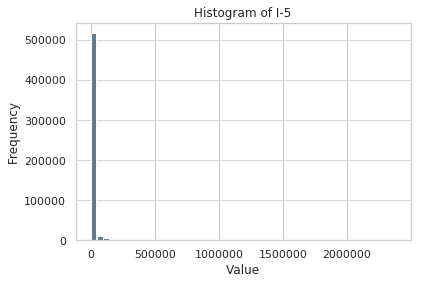

I-6
[    0.   4249.5  8499.  12748.5 16998.  21247.5 25497.  29746.5 33996.
 38245.5 42495. ]


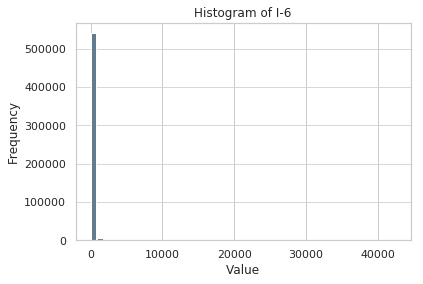

I-7
[   0.   688.9 1377.8 2066.7 2755.6 3444.5 4133.4 4822.3 5511.2 6200.1
 6889. ]


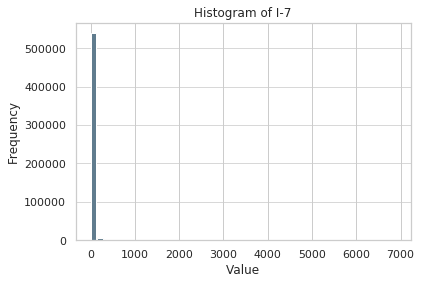

I-8
[   0.   441.4  882.8 1324.2 1765.6 2207.  2648.4 3089.8 3531.2 3972.6
 4414. ]


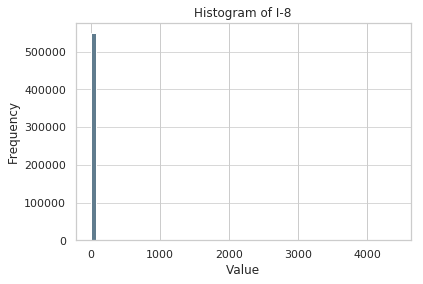

I-9
[    0.   1353.3  2706.6  4059.9  5413.2  6766.5  8119.8  9473.1 10826.4
 12179.7 13533. ]


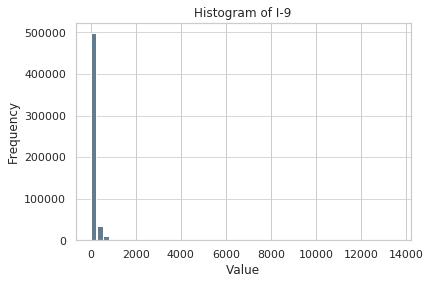

I-10
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]


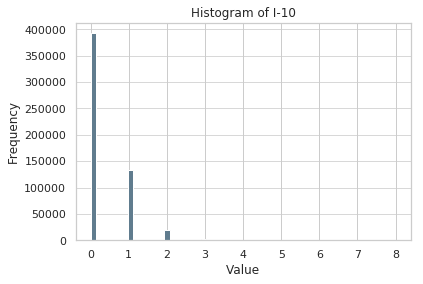

I-11
[  0.   14.7  29.4  44.1  58.8  73.5  88.2 102.9 117.6 132.3 147. ]


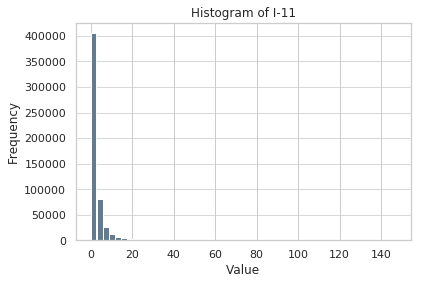

I-12
[  0.   46.1  92.2 138.3 184.4 230.5 276.6 322.7 368.8 414.9 461. ]


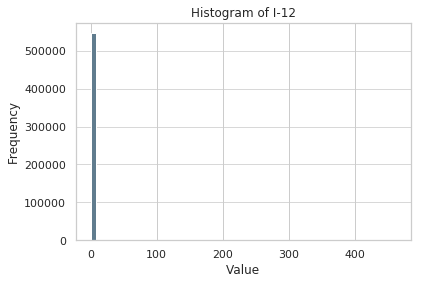

I-13
[   0.   442.5  885.  1327.5 1770.  2212.5 2655.  3097.5 3540.  3982.5
 4425. ]


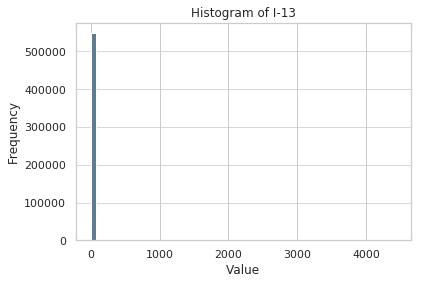

In [23]:
for i in df_pandas.iloc[:,1:14]:
    # The leftmost and rightmost bin edges
    first_edge, last_edge = df_pandas[i].min(), df_pandas[i].max()

    n_equal_bins = 10  # NumPy's default
    bin_edges = np.linspace(start=first_edge, stop=last_edge, num=n_equal_bins + 1, endpoint=True)
    print(i)
    print(bin_edges)
    
    # An "interface" to matplotlib.axes.Axes.hist() method
    df_pandas[i].plot.hist(grid=True, bins=50, rwidth=0.9,color='#607c8e')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of '+ str(i))
    #plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = df_pandas[i].max()
    # Set a clean upper y-axis limit.
    #plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()

In [26]:
# Show top counts for each categorical variable

for cat in df_pandas.iloc[:,14:40]:
    print((df_pandas[cat].value_counts()/len(df_pandas)).head())

98275684      0.499728
1761418852    0.167386
1520359856    0.083753
2364568165    0.049630
3193477969    0.032896
Name: C-1, dtype: float64
950618017    0.114269
544943489    0.043174
953486857    0.038538
486405908    0.036882
678506720    0.035558
Name: C-2, dtype: float64
0             0.033908
3492987491    0.024944
47159414      0.010748
2437138482    0.010015
2861307193    0.009827
Name: C-3, dtype: float64
3247169921    0.035697
0             0.033908
697929425     0.021686
3513153977    0.021127
2245880188    0.019341
Name: C-4, dtype: float64
633879704     0.671519
1291264903    0.156452
1135711049    0.063043
944272590     0.032464
814759540     0.019388
Name: C-5, dtype: float64
2114768079    0.395849
4222442646    0.218091
4268462821    0.185873
0             0.120876
326208445     0.031692
Name: C-6, dtype: float64
478601451     0.021042
3698743741    0.012531
1905591405    0.009126
1583664735    0.007804
1183451220    0.007612
Name: C-7, dtype: float64
185940084     0.59

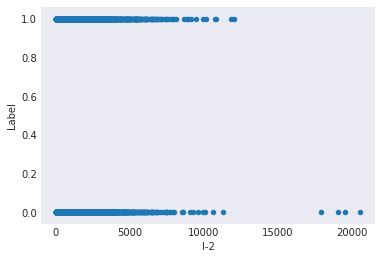

In [34]:
df_pandas.plot(x ='I-2', y='Label', kind = 'scatter')

/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


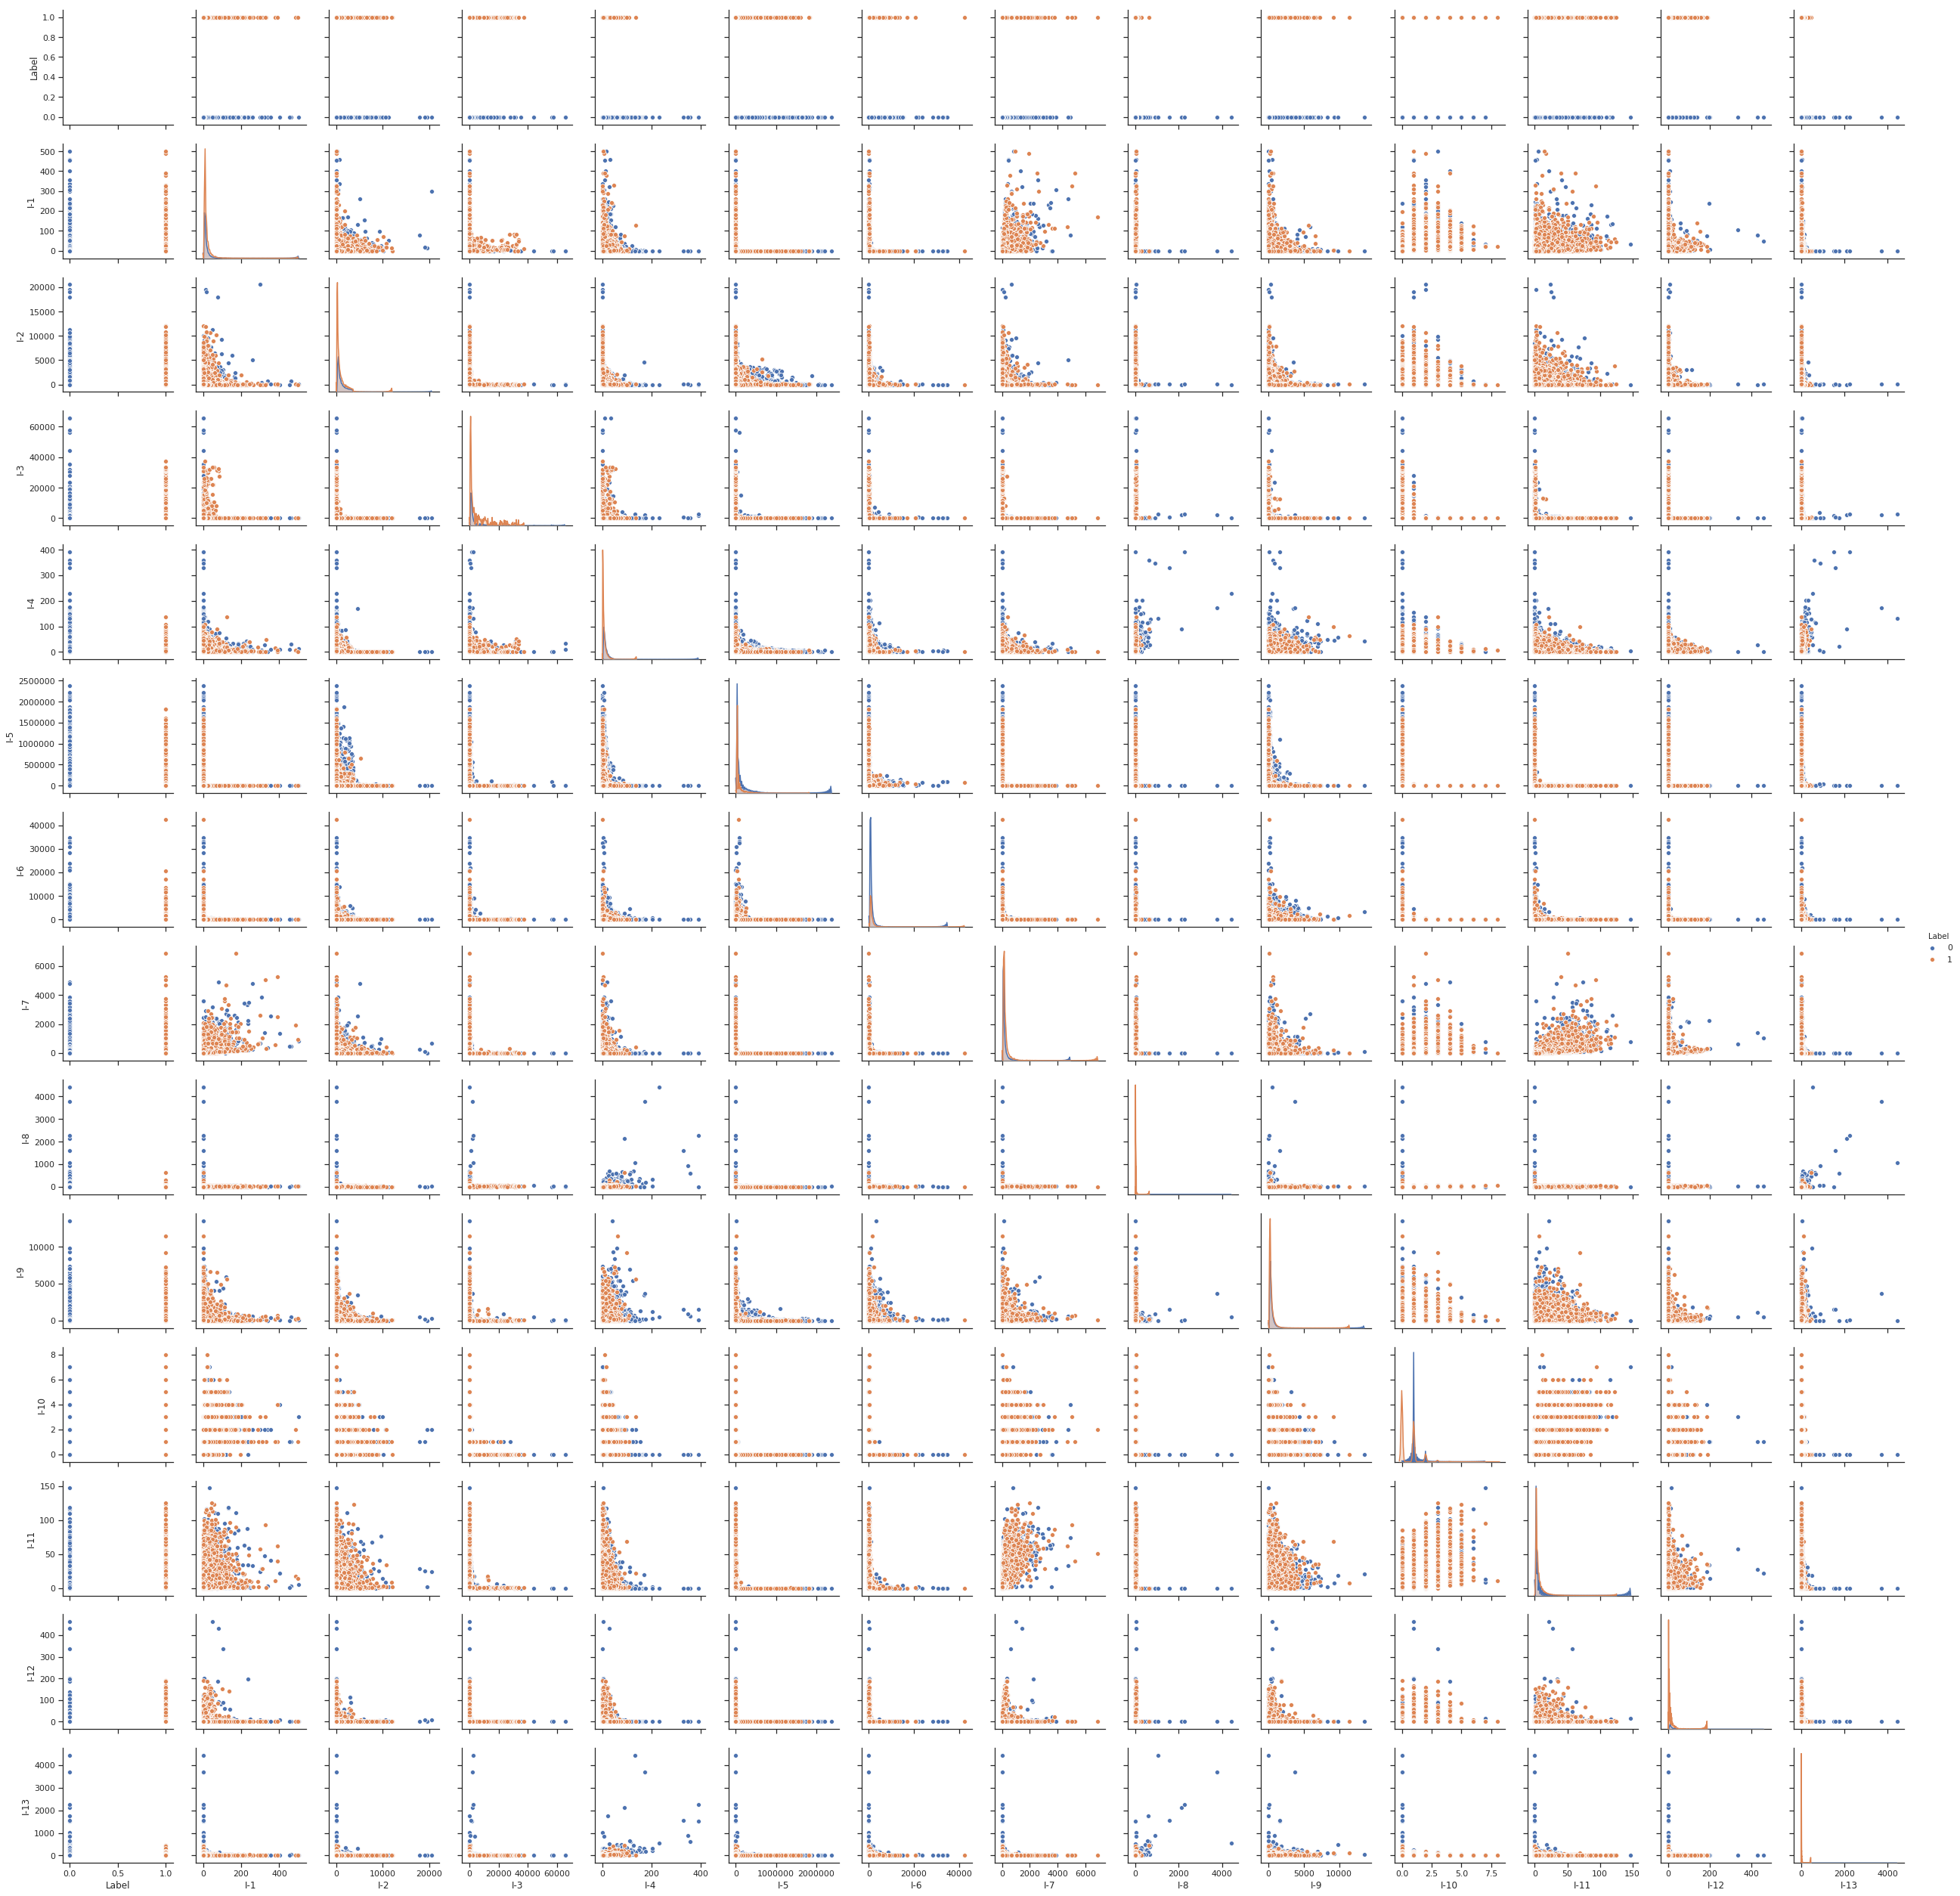

In [13]:
# Plot a scatterplot matrix for I-1 through I-13
s_df = toyDF.select(['Label', 'I-1', 'I-2', 'I-3','I-4', 'I-5', 'I-6','I-7', 'I-8', 'I-9', 'I-10', 'I-11', 'I-12', 'I-13']) 
s_df_pandas = s_df.toPandas()
sns.set(style="ticks")
sns.pairplot(s_df_pandas, hue="Label")

Plot a few boxplots but they don't seem very interesting.

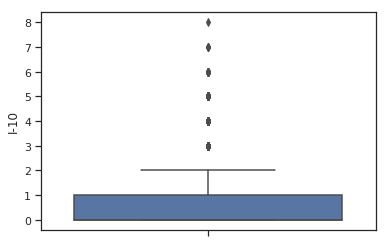

In [24]:
ax = sns.boxplot(y=s_df_pandas["I-10"])

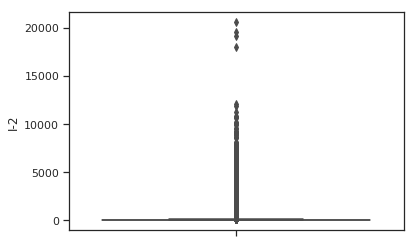

In [27]:
ax = sns.boxplot(y=s_df_pandas["I-2"])

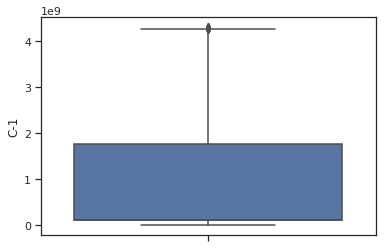

In [47]:
ax = sns.boxplot(y=df_pandas["C-1"])

In [ ]:
#create spark dataframe
trainDF = spark.read.load("data/train_80.parquet")

#convert all Label, Integer columns to Ints
trainDF = trainDF.withColumn("Label", trainDF["Label"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-1", trainDF["I-1"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-2", trainDF["I-2"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-3", trainDF["I-3"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-4", trainDF["I-4"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-5", trainDF["I-5"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-6", trainDF["I-6"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-7", trainDF["I-7"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-8", trainDF["I-8"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-9", trainDF["I-9"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-10", trainDF["I-10"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-11", trainDF["I-11"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-12", trainDF["I-12"].cast(IntegerType()))
trainDF = trainDF.withColumn("I-13", trainDF["I-13"].cast(IntegerType()))

trainDF = trainDF.withColumn('C-1', conv('C-1', 16, 10))
trainDF = trainDF.withColumn('C-2', conv('C-2', 16, 10))
trainDF = trainDF.withColumn('C-3', conv('C-3', 16, 10))
trainDF = trainDF.withColumn('C-4', conv('C-4', 16, 10))
trainDF = trainDF.withColumn('C-5', conv('C-5', 16, 10))
trainDF = trainDF.withColumn('C-6', conv('C-6', 16, 10))
trainDF = trainDF.withColumn('C-7', conv('C-7', 16, 10))
trainDF = trainDF.withColumn('C-8', conv('C-8', 16, 10))
trainDF = trainDF.withColumn('C-9', conv('C-9', 16, 10))
trainDF = trainDF.withColumn('C-10', conv('C-10', 16, 10))
trainDF = trainDF.withColumn('C-11', conv('C-11', 16, 10))
trainDF = trainDF.withColumn('C-12', conv('C-12', 16, 10))
trainDF = trainDF.withColumn('C-13', conv('C-13', 16, 10))
trainDF = trainDF.withColumn('C-14', conv('C-14', 16, 10))
trainDF = trainDF.withColumn('C-15', conv('C-15', 16, 10))
trainDF = trainDF.withColumn('C-16', conv('C-16', 16, 10))
trainDF = trainDF.withColumn('C-17', conv('C-17', 16, 10))
trainDF = trainDF.withColumn('C-18', conv('C-18', 16, 10))
trainDF = trainDF.withColumn('C-19', conv('C-19', 16, 10))
trainDF = trainDF.withColumn('C-20', conv('C-20', 16, 10))
trainDF = trainDF.withColumn('C-21', conv('C-21', 16, 10))
trainDF = trainDF.withColumn('C-22', conv('C-22', 16, 10))
trainDF = trainDF.withColumn('C-23', conv('C-23', 16, 10))
trainDF = trainDF.withColumn('C-24', conv('C-24', 16, 10))
trainDF = trainDF.withColumn('C-25', conv('C-25', 16, 10))
trainDF = trainDF.withColumn('C-26', conv('C-26', 16, 10))
#check if its good
trainDF.show()
# convert all categorial feature columns from strin to long type
trainDF = trainDF.withColumn("C-1", trainDF["C-1"].cast(LongType()))
trainDF = trainDF.withColumn("C-2", trainDF["C-2"].cast(LongType()))
trainDF = trainDF.withColumn("C-3", trainDF["C-3"].cast(LongType()))
trainDF = trainDF.withColumn("C-4", trainDF["C-4"].cast(LongType()))
trainDF = trainDF.withColumn("C-5", trainDF["C-5"].cast(LongType()))
trainDF = trainDF.withColumn("C-6", trainDF["C-6"].cast(LongType()))
trainDF = trainDF.withColumn("C-7", trainDF["C-7"].cast(LongType()))
trainDF = trainDF.withColumn("C-8", trainDF["C-8"].cast(LongType()))
trainDF = trainDF.withColumn("C-9", trainDF["C-9"].cast(LongType()))
trainDF = trainDF.withColumn("C-10", trainDF["C-10"].cast(LongType()))
trainDF = trainDF.withColumn("C-11", trainDF["C-11"].cast(LongType()))
trainDF = trainDF.withColumn("C-12", trainDF["C-12"].cast(LongType()))
trainDF = trainDF.withColumn("C-13", trainDF["C-13"].cast(LongType()))
trainDF = trainDF.withColumn("C-14", trainDF["C-14"].cast(LongType()))
trainDF = trainDF.withColumn("C-15", trainDF["C-15"].cast(LongType()))
trainDF = trainDF.withColumn("C-16", trainDF["C-16"].cast(LongType()))
trainDF = trainDF.withColumn("C-17", trainDF["C-17"].cast(LongType()))
trainDF = trainDF.withColumn("C-18", trainDF["C-18"].cast(LongType()))
trainDF = trainDF.withColumn("C-19", trainDF["C-19"].cast(LongType()))
trainDF = trainDF.withColumn("C-20", trainDF["C-20"].cast(LongType()))
trainDF = trainDF.withColumn("C-21", trainDF["C-21"].cast(LongType()))
trainDF = trainDF.withColumn("C-22", trainDF["C-22"].cast(LongType()))
trainDF = trainDF.withColumn("C-23", trainDF["C-23"].cast(LongType()))
trainDF = trainDF.withColumn("C-24", trainDF["C-24"].cast(LongType()))
trainDF = trainDF.withColumn("C-25", trainDF["C-25"].cast(LongType()))
trainDF = trainDF.withColumn("C-26", trainDF["C-26"].cast(LongType()))
# verify the schema
trainDF.printSchema()


In [49]:
trainDF.count()

36667561

In [50]:
valDF = spark.read.load("validation_20.parquet")
print(valDF.count())
valDF.count()+trainDF.count()

9173056


45840617

In [61]:
feature_list = ['Label']
for i in range(1, 14): feature_list.append('I-'+str(i))
for i in range(1, 27): feature_list.append('C-'+str(i))
feature_list

['Label',
 'I-1',
 'I-2',
 'I-3',
 'I-4',
 'I-5',
 'I-6',
 'I-7',
 'I-8',
 'I-9',
 'I-10',
 'I-11',
 'I-12',
 'I-13',
 'C-1',
 'C-2',
 'C-3',
 'C-4',
 'C-5',
 'C-6',
 'C-7',
 'C-8',
 'C-9',
 'C-10',
 'C-11',
 'C-12',
 'C-13',
 'C-14',
 'C-15',
 'C-16',
 'C-17',
 'C-18',
 'C-19',
 'C-20',
 'C-21',
 'C-22',
 'C-23',
 'C-24',
 'C-25',
 'C-26']

In [ ]:
# Create an empty dataframe with the feature names as rows and columns to store the correlation matrix.
corr_df = pd.DataFrame(index=feature_list, columns=feature_list)

In [57]:
# Test the time it takes to do correlation value for a single pair of features on the 80% train dataset. 
# If it takes too long, will switch to toy dataset.
%time trainDF.corr('Label', 'I-2')

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 5.28 s


0.044321639775202426

In [69]:
# Fill in the correlation matrix using the 80% train dataset. (This takes ~2 hours to run)
for i in range(40):
    for j in range(i):
        row = feature_list[i]
        col = feature_list[j]
        corr_df[row][col] = trainDF.corr(row, col)
    print('finished row ', i)
        
corr_df

finished row  0
finished row  1
finished row  2
finished row  3
finished row  4
finished row  5
finished row  6
finished row  7
finished row  8
finished row  9
finished row  10
finished row  11
finished row  12
finished row  13
finished row  14
finished row  15
finished row  16
finished row  17
finished row  18
finished row  19
finished row  20
finished row  21
finished row  22
finished row  23
finished row  24
finished row  25
finished row  26
finished row  27
finished row  28
finished row  29
finished row  30
finished row  31
finished row  32
finished row  33
finished row  34
finished row  35
finished row  36
finished row  37
finished row  38
finished row  39


,Label,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,...,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
Label,1,0.103828,0.0443216,0.00984961,-0.0556405,-0.076566,-0.055773,0.0847263,-0.0274725,0.0240073,...,0.0828979,0.00311758,-0.00363352,-0.0117655,0.00178357,0.0300672,-0.053632,0.00295828,-0.00783716,-0.0179288
I-1,0.103828,1,0.0339716,0.0383809,0.0806906,-0.0687702,-0.0581138,0.476672,0.0965647,0.0679653,...,0.0677893,-0.00792124,0.0328549,0.0376262,-0.00585805,0.0112698,-0.00802536,0.00136665,0.0511387,0.0313324
I-2,0.0443216,0.0339716,1,-0.00827489,-0.0813955,-0.00630637,-0.0132656,0.0252189,-0.0279426,-0.00474384,...,0.00786537,0.0045304,-0.0184298,-0.019165,0.0115305,0.00702191,-0.00343405,0.00120468,-0.0101652,-0.0135678
I-3,0.00984961,0.0383809,-0.00827489,1,0.0418826,-0.00346479,0.00557462,0.000404332,0.0447908,-0.000454595,...,0.00668458,-0.00465369,0.0140431,0.0246724,0.000865265,-0.00455683,0.000514754,-0.00500954,0.0398055,0.0427437
I-4,-0.0556405,0.0806906,-0.0813955,0.0418826,1,-0.094478,0.0156165,0.0383694,0.504521,0.194227,...,0.0359684,-0.013026,0.0193397,0.0371399,-0.0129298,0.000710357,0.0229493,0.00795253,0.0251192,0.051273
I-5,-0.076566,-0.0687702,-0.00630637,-0.00346479,-0.094478,1,0.00212302,-0.056095,-0.109379,-0.0684271,...,-0.0171276,0.0153618,-0.00565852,0.00781907,0.00349684,0.0165781,0.00680801,-0.000406601,-0.0125962,0.00813884
I-6,-0.055773,-0.0581138,-0.0132656,0.00557462,0.0156165,0.00212302,1,-0.0269472,0.0220709,0.187072,...,0.0193228,-0.00748167,-0.0274806,-0.0385101,-0.00860771,-0.0052604,-0.00113003,0.00756135,-0.0332766,-0.0301266
I-7,0.0847263,0.476672,0.0252189,0.000404332,0.0383694,-0.056095,-0.0269472,1,0.0767185,0.232887,...,0.0315783,-0.0114381,0.0368564,0.0387182,-0.00967227,0.0156128,-0.00750516,-0.00207325,0.0699821,0.0247664
I-8,-0.0274725,0.0965647,-0.0279426,0.0447908,0.504521,-0.109379,0.0220709,0.0767185,1,0.206266,...,0.0485863,-0.0286486,-0.0138311,-0.00941861,-0.0172907,0.00972455,0.0446256,0.0353521,-0.0157391,0.00823387
I-9,0.0240073,0.0679653,-0.00474384,-0.000454595,0.194227,-0.0684271,0.187072,0.232887,0.206266,1,...,0.0439637,-0.0156515,0.00393329,-0.00496289,-0.0137132,3.71683e-05,0.0180635,0.000711694,0.0161197,-0.00116052


In [66]:
corr_df.to_pickle("./correlation.pkl")

In [96]:
# Create a new Pandas dataframe to store only correlation values > 0.1 and hide all the NAs for pretty printing.
s_corr_df = corr_df[corr_df > 0.1]
s_corr_df = s_corr_df[s_corr_df != 1]
s_corr_df = s_corr_df.dropna(how='all', axis = 1)
s_corr_df = s_corr_df.dropna(how='all')
s_corr_df.fillna('', inplace=True)
s_corr_df

,Label,I-1,I-4,I-6,I-7,I-8,I-9,I-10,I-11,I-13,C-9,C-12,C-16,C-17,C-20,C-22,C-24,C-25,C-26
Label,,0.103828,,,,,,0.191794,0.15831,,0.100216,,,,,,,,
I-1,0.103828,,,,0.476672,,,0.463674,0.303609,,,,,,,,,,
I-4,,,,,,0.504521,0.194227,0.15784,,0.613096,0.143039,,,,,,,,
I-6,,,,,,,0.187072,,,,,,,,,,,,
I-7,,0.476672,,,,,0.232887,0.250686,0.683299,,,,,,,,,,
I-8,,,0.504521,,,,0.206266,0.156517,0.139176,0.630637,0.151928,,,,,,,,
I-9,,,0.194227,0.187072,0.232887,0.206266,,,0.403867,0.19242,,,,,,,,,
I-10,0.191794,0.463674,0.15784,,0.250686,0.156517,,,0.386657,,0.190659,,,,,,,,
I-11,0.15831,0.303609,,,0.683299,0.139176,0.403867,0.386657,,,0.164274,,,,,,,,
I-13,,,0.613096,,,0.630637,0.19242,,,,,,,,,,,,


In [97]:
s_corr_df.to_pickle("./s_correlation.pkl")

/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


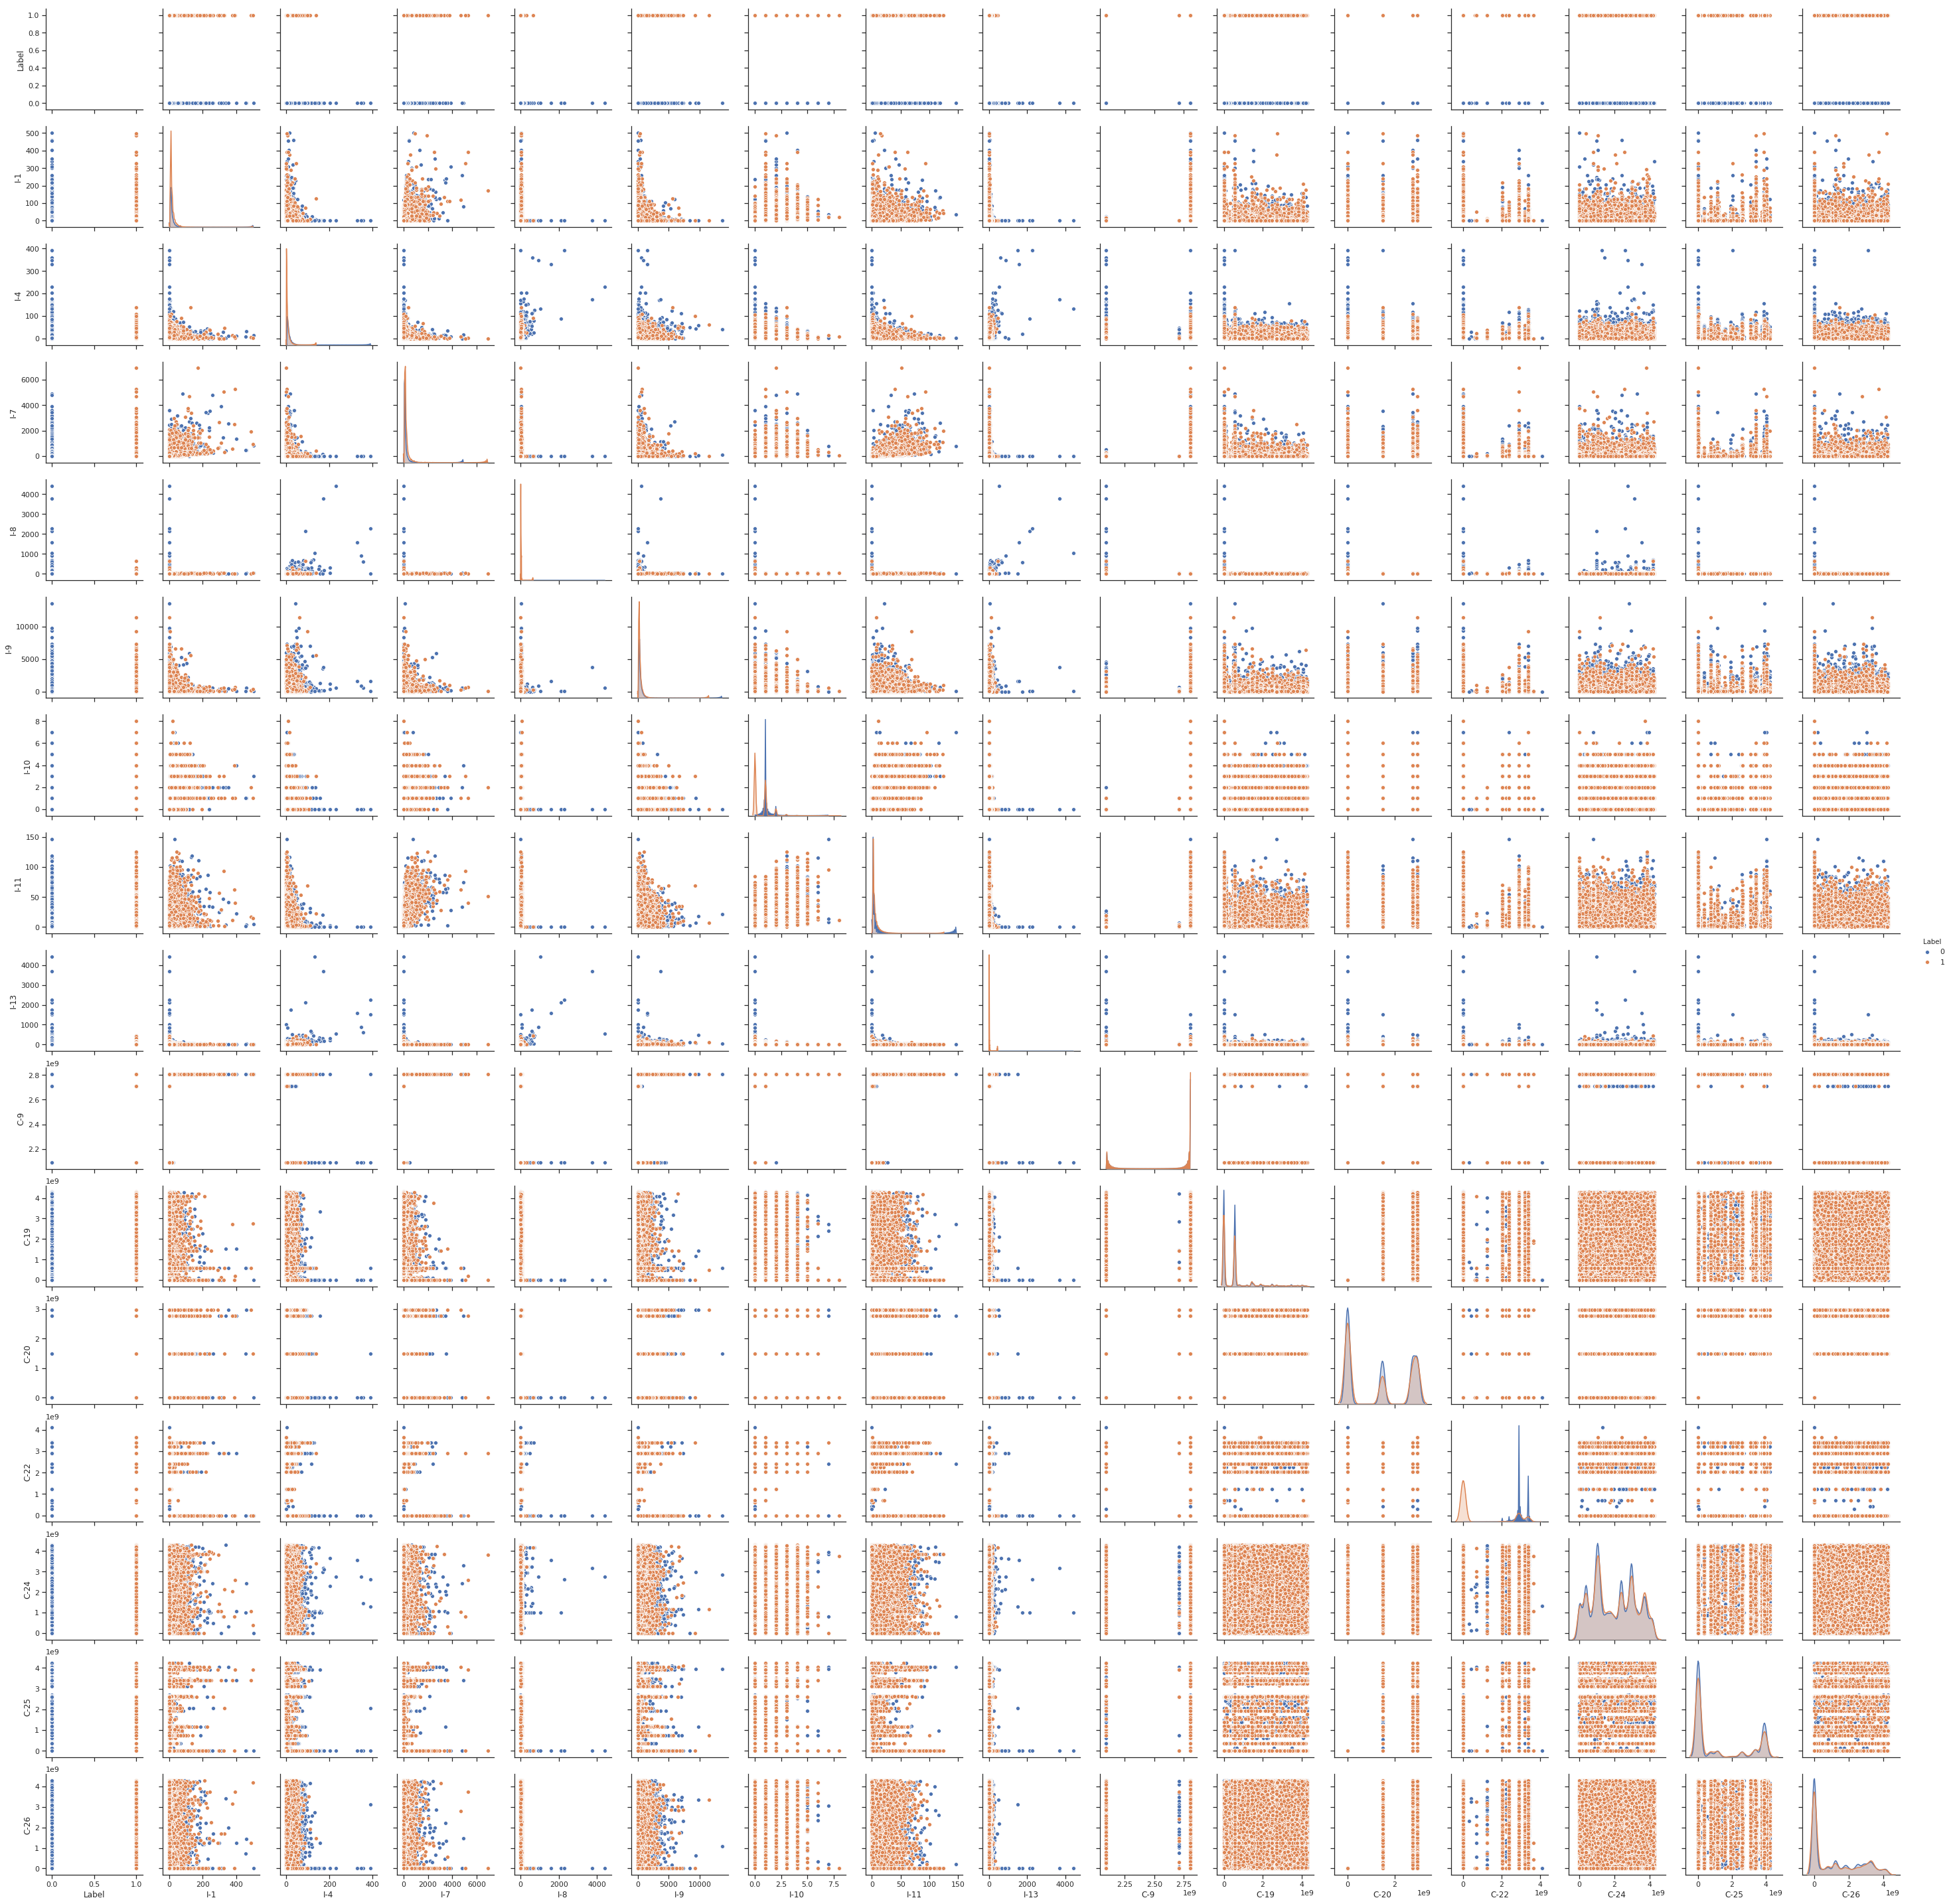

In [98]:
# Plot a scatterplot matrix for the rows/columns from the table above.
s_df = toyDF.select(['Label', 'I-1', 'I-4', 'I-7', 'I-8', 'I-9','I-10', 'I-11', 'I-13', 'C-9', 'C-19', 'C-20', 'C-22', 'C-24', 'C-25', 'C-26']) 
          #  .sample(withReplacement=False, fraction=0.5, seed=42)
s_df_pandas = s_df.toPandas()
sns.set(style="ticks")
sns.pairplot(s_df_pandas, hue="Label")

In [ ]:
sns.lmplot(y = 'I-4', x = 'I-8', data=df_pandas)
sns.lmplot(y = 'I-7', x = 'I-11', data=df_pandas)
sns.lmplot(y = 'C-19', x = 'C-20', data=df_pandas)
sns.lmplot(y = 'C-20', x = 'C-26', data=df_pandas)
sns.lmplot(y = 'I-8', x = 'I-13', data=df_pandas)

/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


**3. EDA & Discussion of Challenges**

Determine 2-3 relevant EDA tasks that will help you make
decisions about how you implement the algorithm to be scalable. Discuss any challenges that
you anticipate based on the EDA you perform.

In [4]:
# load the raw data into an RDD
wholeRDD = sc.textFile('train.txt')
trainRDD, testRDD = wholeRDD.randomSplit([0.8,0.2], seed = 25)
toyRDD = trainRDD.sample(False, 0.01)
#wholeDF = wholeRDD.toDF()
#wholeDF.write.parquet("whole.parquet")

In [5]:
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
   # print('line', line)
    features = line.split('\t')
    #print(features)
   # features,label = fields[1:], fields[0]
    for i in range(14): 
        if features[i] == '': features[i] = None
        else:
          #  print(features[i])
            features[i] = int(features[i], 10)
    for i in range(14, 40): 
        if features[i] == '': features[i] = None
        else:
          #  print(features[i])
            features[i] = int(features[i], 16)
   # print('final',features)
    yield features        

toyRDD = toyRDD.flatMap(parse) 
#print(toyRDD)

In [6]:
# Check parquet conversion wall time.
%time pd_df = toyRDD.toDF().toPandas()

CPU times: user 7.23 s, sys: 740 ms, total: 7.97 s
Wall time: 2min 52s


In [7]:
pd_df.describe()


,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,...,_31,_32,_33,_34,_35,_36,_37,_38,_39,_40
count,367150.000000,200559.000000,367150.000000,288650.000000,287865.000000,3.577460e+05,284982.000000,351276.000000,366953.000000,351276.000000,...,3.671500e+05,3.671500e+05,2.054690e+05,2.054690e+05,3.547020e+05,8.731200e+04,3.671500e+05,3.547020e+05,2.054690e+05,2.054690e+05
mean,0.256151,3.495251,105.993066,25.782955,7.333062,1.869903e+04,118.661224,16.360816,12.559543,106.409655,...,2.552371e+09,2.196038e+09,1.117894e+09,2.408332e+09,2.113577e+09,3.042618e+09,1.429742e+09,2.050178e+09,2.214859e+09,2.207464e+09
std,0.436507,8.983615,386.853328,350.437416,8.938672,6.993637e+04,882.830994,62.442742,20.252005,219.072373,...,1.536835e+09,1.246248e+09,1.000864e+09,6.577218e+08,1.282817e+09,3.105837e+08,9.487729e+08,1.188522e+09,1.722317e+09,1.161970e+09
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.303677e+08,2.611126e+06,2.271388e+06,1.480634e+09,2.718100e+04,4.083490e+08,6.356847e+08,4.647400e+04,2.045441e+06,1.841100e+05
25%,0.000000,0.000000,0.000000,2.000000,2.000000,3.260000e+02,8.000000,1.000000,2.000000,10.000000,...,8.812059e+08,1.143429e+09,5.681843e+08,1.480634e+09,1.005489e+09,2.905629e+09,8.519208e+08,1.013919e+09,2.045441e+06,1.238795e+09
50%,0.000000,1.000000,3.000000,6.000000,4.000000,2.816000e+03,33.000000,3.000000,7.000000,38.000000,...,3.569057e+09,2.130031e+09,5.681843e+08,2.757291e+09,2.017089e+09,2.905629e+09,9.745937e+08,2.056646e+09,2.643702e+09,2.341168e+09
75%,1.000000,3.000000,35.000000,17.000000,10.000000,1.015900e+04,103.000000,11.000000,19.000000,110.000000,...,3.854202e+09,3.256631e+09,1.440560e+09,2.972003e+09,3.282943e+09,3.386123e+09,1.111469e+09,3.008312e+09,3.904386e+09,3.202886e+09
max,1.000000,417.000000,13426.000000,65535.000000,657.000000,2.219437e+06,431037.000000,6042.000000,5664.000000,11934.000000,...,3.854202e+09,4.294847e+09,4.294636e+09,2.972003e+09,4.294964e+09,3.439149e+09,3.686041e+09,4.294865e+09,4.252078e+09,4.294794e+09


Look at the number of missing values in the entire train.txt (100% of data). 

In [41]:
def emit_NA(line):
    features = line.split('\t')
    for i in range(len(features)):
        if features[i] == '': 
            yield i, 1
            
whole_ct = wholeRDD.count()
print('Training Set Line Count: ', whole_ct)
wholeRDD.flatMap(emit_NA) \
        .reduceByKey(lambda x, y: x+y) \
        .map(lambda line: (line[0], line[1]/whole_ct)) \
        .sortBy(lambda x: x[1]) \
        .collect()

Training Set Line Count:  45840617


[(8, 0.000496786507040252),
 (5, 0.02580936028849699),
 (16, 0.03401945920579559),
 (17, 0.03401945920579559),
 (25, 0.03401945920579559),
 (29, 0.03401945920579559),
 (34, 0.03401945920579559),
 (37, 0.03401945920579559),
 (7, 0.04325565687739325),
 (9, 0.04325565687739325),
 (11, 0.04325565687739325),
 (19, 0.12086715586747011),
 (3, 0.2146447330759095),
 (4, 0.2167808736082239),
 (13, 0.2167808736082239),
 (6, 0.2236516144623446),
 (32, 0.4400651500829494),
 (33, 0.4400651500829494),
 (38, 0.4400651500829494),
 (39, 0.4400651500829494),
 (1, 0.45360550011794126),
 (10, 0.45360550011794126),
 (35, 0.7625349588990044),
 (12, 0.7650780965709951)]

Look at the number of missing values in the 80% train dataset.

In [42]:
def emit_NA(line):
    features = line.split('\t')
    for i in range(len(features)):
        if features[i] == '': 
            yield i, 1
            
train_ct = trainRDD.count()
print('Training Set Line Count: ', train_ct)
trainRDD.flatMap(emit_NA) \
        .reduceByKey(lambda x, y: x+y) \
        .map(lambda line: (line[0], line[1]/train_ct)) \
        .sortBy(lambda x: x[1]) \
        .collect()

Training Set Line Count:  36672431


[(8, 0.0004963674210744306),
 (5, 0.0258073428510916),
 (16, 0.034034831233304384),
 (17, 0.034034831233304384),
 (25, 0.034034831233304384),
 (29, 0.034034831233304384),
 (34, 0.034034831233304384),
 (37, 0.034034831233304384),
 (7, 0.043281041281392006),
 (9, 0.043281041281392006),
 (11, 0.043281041281392006),
 (19, 0.12088833161892104),
 (3, 0.2145877375841269),
 (4, 0.2167654497734279),
 (13, 0.2167654497734279),
 (6, 0.22369902338898667),
 (32, 0.4400463388969223),
 (33, 0.4400463388969223),
 (38, 0.4400463388969223),
 (39, 0.4400463388969223),
 (1, 0.453685549234519),
 (10, 0.453685549234519),
 (35, 0.7624707235797922),
 (12, 0.7651111266662415)]

Features 2, 14, 15, 18, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, and 36 have no missing values at all. Features 12 and 35 both have a significant portion of missing values (> 76%). Features 1, 10, 32, 33, 38, 39 contain 44-45% of missing values. We are also seeing similarities in the following features: 

1) features 7, 9, 11 with the same percentage (4.328%)

2) features 1, 10 with the same percentage (45.369%)

3) features 16, 17, 25, 29, 34, 37 with the same percentage (3.403%)

4) features 32, 33, 38, 39 with the same percentage (44.005%)

In [ ]:
# Using RDD, compute preliminary stats for each feature. Results are then converted to Pandas for pretty printing. 
def emit(feature):
    if feature != '': 
        yield int(feature)

result = []
train_ct = trainRDD.count()
for i in range(1,14):
    tempRDD = trainRDD.map(lambda line: line.split('\t')[i]) \
                      .flatMap(emit) \
                      .cache()
    feature_max = tempRDD.max()
    feature_min = tempRDD.min()
    feature_mean = tempRDD.mean()
    feature_sd = tempRDD.stdev()
    feature_count = tempRDD.count()
    feature_distinct = tempRDD.distinct() \
                              .count()
    result.append([i, 'Integer', feature_min, feature_max, feature_mean, feature_sd, 
                   feature_count, 1-feature_count/train_ct, feature_distinct])
    print(result)

for i in range(14,40):
    tempRDD = trainRDD.map(lambda line: line.split('\t')[i]) \
                      .filter(lambda x: x!='') \
                      .cache()
    feature_count = tempRDD.count()
    feature_distinct = tempRDD.distinct() \
                              .count()
    result.append([i, 'Categorical', None, None, None, None, feature_count, 
                   1-feature_count/train_ct, feature_distinct])

In [108]:
df2 = pd.DataFrame(result,
                   columns=['Feature #', 'Type', 'Min', 'Max', 'Mean', 'SD', '# of Non-NAs', '% of NAs', '# of Distinct Elements'])
df2.round(4)
df2.to_pickle("./summary.pkl")


In [109]:
df2.round(4)


,Feature #,Type,Min,Max,Mean,SD,# of Non-NAs,% of NAs,# of Distinct Elements
0,1,Integer,0.0,5775.0,3.5019,9.4510,20034679,0.4537,611
1,2,Integer,-3.0,257675.0,105.8580,391.8554,36672431,0.0000,8970
2,3,Integer,0.0,65535.0,26.9128,399.1019,28802977,0.2146,13007
3,4,Integer,0.0,969.0,7.3233,8.7958,28723115,0.2168,467
4,5,Integer,0.0,2693697.0,18543.2412,69345.7436,35726013,0.0258,443808
5,6,Integer,0.0,431037.0,116.0596,384.1878,28468844,0.2237,10881
6,7,Integer,0.0,34536.0,16.3282,65.6497,35085210,0.0433,3911
7,8,Integer,0.0,6047.0,12.5156,16.5658,36654228,0.0005,1245
8,9,Integer,0.0,29019.0,106.1013,220.3923,35085210,0.0433,6954
9,10,Integer,0.0,11.0,0.6175,0.6840,20034679,0.4537,12


In [113]:
# Bin all count features into 7 bins to see if there's any timestamp features. Conclusion is no.
def emit(feature):
    if feature != '': 
        yield int(feature)
        
for i in range(1,14):
    temp = trainRDD.map(lambda line: line.split('\t')[i]) \
                   .flatMap(emit) \
                   .histogram(7)
    print('Feature {}: {}'.format(i, temp))

Feature 1: ([0, 825, 1650, 2475, 3300, 4125, 4950, 5775], [20034646, 27, 4, 0, 1, 0, 1])
Feature 2: ([-3.0, 36808.142857142855, 73619.28571428571, 110430.42857142857, 147241.57142857142, 184052.71428571426, 220863.85714285713, 257675], [36672430, 0, 0, 0, 0, 0, 1])
Feature 3: ([0.0, 9362.142857142857, 18724.285714285714, 28086.428571428572, 37448.57142857143, 46810.71428571428, 56172.857142857145, 65535], [28796242, 2822, 2174, 1319, 181, 43, 196])
Feature 4: ([0.0, 138.42857142857142, 276.85714285714283, 415.2857142857142, 553.7142857142857, 692.1428571428571, 830.5714285714284, 969], [28721914, 890, 209, 51, 31, 17, 3])
Feature 5: ([0.0, 384813.85714285716, 769627.7142857143, 1154441.5714285714, 1539255.4285714286, 1924069.285714286, 2308883.1428571427, 2693697], [35421053, 252065, 41600, 8303, 2557, 343, 92])
Feature 6: ([0.0, 61576.71428571428, 123153.42857142857, 184730.14285714284, 246306.85714285713, 307883.5714285714, 369460.2857142857, 431037], [28468797, 37, 3, 2, 2, 1, 2])
F

In [121]:
# Bin all count features into 20 bins to observe data distribution. Feature I-5 has been plotted as a bar graph.
def emit(feature):
    if feature != '': 
        yield int(feature)
        
for i in range(1,14):
    temp = trainRDD.map(lambda line: line.split('\t')[i]) \
                   .flatMap(emit) \
                   .histogram(20)
    print('Feature {}: {}'.format(i, temp))

Feature 1: ([0.0, 288.75, 577.5, 866.25, 1155.0, 1443.75, 1732.5, 2021.25, 2310.0, 2598.75, 2887.5, 3176.25, 3465.0, 3753.75, 4042.5, 4331.25, 4620.0, 4908.75, 5197.5, 5486.25, 5775], [20033579, 981, 90, 15, 8, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])
Feature 2: ([-3.0, 12880.9, 25764.8, 38648.7, 51532.6, 64416.5, 77300.4, 90184.3, 103068.2, 115952.09999999999, 128836.0, 141719.9, 154603.8, 167487.69999999998, 180371.6, 193255.5, 206139.4, 219023.3, 231907.19999999998, 244791.1, 257675], [36672265, 163, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Feature 3: ([0.0, 3276.75, 6553.5, 9830.25, 13107.0, 16383.75, 19660.5, 22937.25, 26214.0, 29490.75, 32767.5, 36044.25, 39321.0, 42597.75, 45874.5, 49151.25, 52428.0, 55704.75, 58981.5, 62258.25, 65535], [28789391, 4831, 2316, 1571, 653, 451, 828, 918, 481, 688, 339, 216, 25, 27, 16, 12, 17, 11, 18, 168])
Feature 4: ([0.0, 48.45, 96.9, 145.35000000000002, 193.8, 242.25, 290.70000000000005, 339.15000000000003, 387.6, 436.05, 484

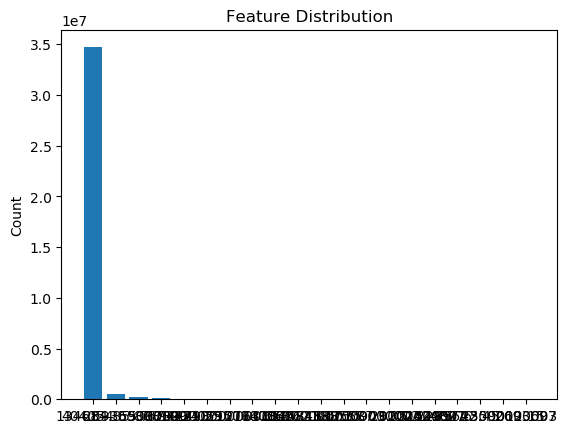

In [124]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = (134684.85, 269369.7, 404054.55000000005, 538739.4, 673424.25, 808109.1000000001, 942793.9500000001, 1077478.8, 1212163.6500000001, 1346848.5, 1481533.35, 1616218.2000000002, 1750903.05, 1885587.9000000001, 2020272.75, 2154957.6, 2289642.45, 2424327.3000000003, 2559012.15, 2693697)
y_pos = np.arange(len(objects))
performance = [34696524, 513621, 235177, 133614, 69735, 32436, 17272, 11832, 6568, 3386, 1954, 2006, 1080, 325, 148, 116, 120, 45, 40, 14]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Feature Distribution')

plt.show()

In [127]:
import seaborn as sns; sns.set()
corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
        
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data)

In [ ]:
# Find the number of data points without any missing values. 

def NonNA(features):
    for feature in features:
        if feature == '': return False
    return True
        
compTrainRDD = trainRDD.map(lambda line: line.split('\t')) \
                       .filter(NonNA) 
CTrain = compTrainRDD.collect()
CTrain 

In [120]:
len(CTrain)

605255

In [40]:
# Find the number of clicks in the 100% train dataset.
wholeRDD.map(lambda line: int(line.split('\t')[0])) \
        .sum()

11745438

In [39]:
# Find the number of clicks in the 80% train dataset.
trainRDD.map(lambda line: int(line.split('\t')[0])) \
        .sum()

9394720

In [6]:
# helper function
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t'))
    features,label = fields[1:], fields[0]
    for i in range(39): 
        if features[i] != '': features[i] = int(features[i], 16)
    return(features, label)

In [7]:
# cache the training set
trainRDDCached = trainRDD.sample(False, 0.01) \
                         .map(parse) \
                         .cache()

In [8]:
trainRDDCached.take(5)

[(array(['', '1', '35', '3', '467987', '13831', '0', '4', '68', '', '0', '',
         '3', '17614188', '40400978', '19609441', '25905420', '63387970',
         '42224426', '16870718', '18594008', '20934284', '22743138',
         '34063042', '42204967', '42160471', '29950264', '38717168',
         '33335464', '13036768', '29579198', '56818426', '14806338',
         '25795375', '', '85192078', '86156342', '39359704', '23749395'],
        dtype='<U8'), '0'),
 (array(['0', '1', '7', '0', '13703', '4', '53', '2', '16', '0', '8', '0',
         '1', '98275684', '10783541', '40470733', '15101119', '63387970',
         '21147680', '47860145', '33699810', '28059169', '36663133',
         '19691136', '21571842', '15010379', '13115252', '16650788',
         '21884110', '38542024', '12598621', '56818426', '14806338',
         '12764087', '', '85192078', '28256515', '40425415', '25552521'],
        dtype='<U8'), '0'),
 (array(['2', '0', '1', '', '392', '0', '2', '0', '0', '1', '1', '', '',
         

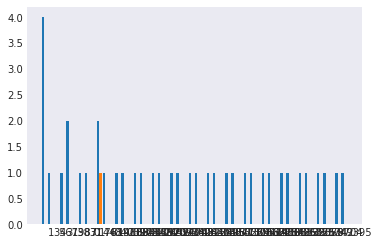

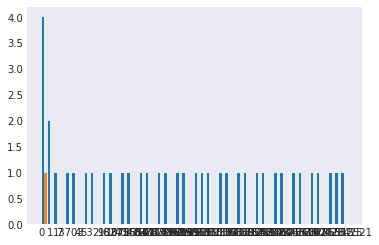

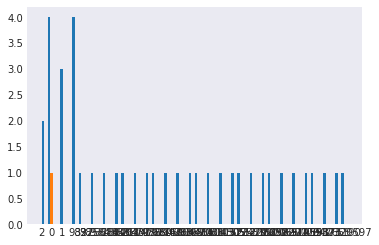

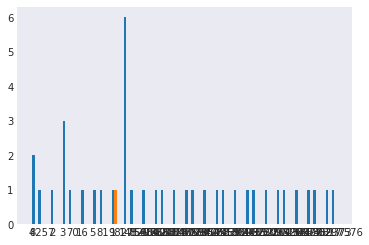

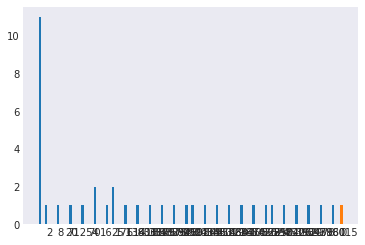

In [10]:
trainSubSet = trainRDDCached.collect()
for feature in range(5):
    plt.hist(trainSubSet[feature], bins=50)
    plt.show()

In [8]:
FIELDS=list(range (1,41))
for i in range(len(FIELDS)-1): 
    FIELDS[i] = 'Feature '+ str(FIELDS[i])
FIELDS[39] = 'Label'
print(FIELDS)

['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 'Feature 13', 'Feature 14', 'Feature 15', 'Feature 16', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20', 'Feature 21', 'Feature 22', 'Feature 23', 'Feature 24', 'Feature 25', 'Feature 26', 'Feature 27', 'Feature 28', 'Feature 29', 'Feature 30', 'Feature 31', 'Feature 32', 'Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37', 'Feature 38', 'Feature 39', 'Label']


In [32]:
# take a 1000 point sample for EDA
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [33]:
sample_df

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Label
0,0,1,7,2,6465,118,16,5,81,0,...,21300305,79348475,27572905,10189586,,11114689,25653121,2045441,42297184,1
1,0,1040,1,1,25113,516,2,1,409,0,...,78817120,,,19430394,29056294,85192078,29342544,,,0
2,0,17,20,2,12881,80,2,5,104,0,...,25802406,56818426,29720029,21057000,,97459373,24121462,2045441,40852012,0
3,1,34,7,9,1362,40,8,72,869,1,...,38384610,,,14619636,,85192078,24342454,,,0
4,,0,2,3,29223,41,1,3,41,,...,15255112,76202360,27572905,90711455,,85192078,39555280,39043860,41480323,0
5,0,0,1,,5969,50,19,18,120,0,...,14447196,56818426,14806338,42335747,,11114689,40734403,20510247,31431244,0
6,2,1574,,4,17,1,21,24,150,2,...,34271575,,,20995735,33861227,11114689,16311062,,,1
7,0,2,48,3,214321,,,18,,0,...,31535302,,,32138192,33861227,85192078,41844954,,,0
8,,-1,344,21,5805185,,0,22,70,,...,25585262,56818426,14806338,10709627,,24784944,37609907,39359704,26745377,0
9,,20,,0,37,1414,5,0,86,,...,37125236,14405604,29720029,32034969,,11114689,11688726,11468631,33604431,0


In [69]:
for i in range(1,39):
    current = 'Feature '+str(i)
    print('='*10, current, '='*10)
    print(sample_df['Feature '+str(i)].describe())

========== Feature 1 ==========
count     1000
unique      37
top           
freq       448
Name: Feature 1, dtype: object
========== Feature 2 ==========
count     1000
unique     212
top          0
freq       179
Name: Feature 2, dtype: object
========== Feature 3 ==========
count     1000
unique      95
top           
freq       226
Name: Feature 3, dtype: object
========== Feature 4 ==========
count     1000
unique      46
top           
freq       204
Name: Feature 4, dtype: object
========== Feature 5 ==========
count     1000
unique     796
top          0
freq        29
Name: Feature 5, dtype: object
========== Feature 6 ==========
count     1000
unique     231
top           
freq       236
Name: Feature 6, dtype: object
========== Feature 7 ==========
count     1000
unique     111
top          0
freq       227
Name: Feature 7, dtype: object
========== Feature 8 ==========
count     1000
unique      53
top          0
freq       101
Name: Feature 8, dtype: object
========== Featu

In [67]:
sample_df['Feature 1'].describe()

count     1000
unique      37
top           
freq       448
Name: Feature 1, dtype: object

**4. Algorithm Implementation**

Develop a ‘homegrown’ implementation of the algorithm, apply it
to the training dataset and evaluate your results on the test set.

**5. Application of Course Concepts**

Pick 3-5 key course concepts and discuss how your work on
this assignment illustrates an understanding of these concepts.

List of Questions:

1. 

Pauline's Breiman Transformation (Below)

In [21]:
toyDF.show()

Py4JJavaError: An error occurred while calling o202.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 76.0 failed 1 times, most recent failure: Lost task 0.0 in stage 76.0 (TID 280, localhost, executor driver): java.io.FileNotFoundException: File file:/media/notebooks/Final_Project/toy_naga.parquet/part-00001-c21319db-27b4-46c6-a912-d70d12f32754-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:131)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:182)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:109)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.scan_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3273)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3254)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3253)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2698)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: File file:/media/notebooks/Final_Project/toy_naga.parquet/part-00001-c21319db-27b4-46c6-a912-d70d12f32754-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:131)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:182)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:109)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.scan_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
